# Customer Profiling in Credit Cards

By analyzing the attributes in the csv, the goal is to create customer profiles based on demographics, financial behavior, and loan history. Can be utilized to identify safe and risky customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import numpy
import sklearn
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [2]:
df = pd.read_csv("./data/credit_card_dataset.csv")

In [3]:
# Potential attributes to focus on:
# Age, Gender, Occupation, Marital Status, Family Size, Income, Expenditure, Use Frequency, Loan Category, Loan Amount, Overdue, Debt Record, Returned Cheque, Dishonour of Bill

# Defining constants for the headers to allow for QoL

AGE, GENDER, OCCUPATION, MARITIAL_STATUS, FAM_SIZE, INCOME, EXPENDITURE, USE_FREQ, LOAN_CAT, LOAN_AMOUNT, OVERDUE, DEBT_RECORD, RETURNED_CHEQUE, DISHONORED_BILL = "Age", "Gender", "Occupation", "Marital Status", "Family Size", "Income", "Expenditure", "Use Frequency", "Loan Category", "Loan Amount", "Overdue", " Debt Record", " Returned Cheque", " Dishonour of Bill"


features = [AGE, GENDER, OCCUPATION, MARITIAL_STATUS, FAM_SIZE, INCOME, EXPENDITURE, USE_FREQ, LOAN_CAT, LOAN_AMOUNT, OVERDUE, DEBT_RECORD, RETURNED_CHEQUE, DISHONORED_BILL]

customer_profiles = df[features] # Dataframe which holds the attributes that have potential

customer_profiles

,Age,Gender,Occupation,Marital Status,Family Size,Income,Expenditure,Use Frequency,Loan Category,Loan Amount,Overdue,Debt Record,Returned Cheque,Dishonour of Bill
0,30,MALE,BANK MANAGER,SINGLE,4,50000.0,22199.0,6,HOUSING,"10,00,000",5,"42,898",6,9
1,44,MALE,PROFESSOR,MARRIED,6,51000.0,19999.0,4,SHOPPING,"50,000",3,"33,999",1,5
2,30,FEMALE,DENTIST,SINGLE,3,58450.0,27675.0,5,TRAVELLING,"75,000",6,"20,876",3,1
3,29,MALE,TEACHER,MARRIED,5,45767.0,12787.0,3,GOLD LOAN,"6,00,000",7,"11,000",0,4
4,34,MALE,POLICE,SINGLE,4,43521.0,11999.0,3,AUTOMOBILE,"2,00,000",2,"43,898",1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,32,FEMALE,DIETICIAN,SINGLE,3,45060.0,24989.0,6,TRAVELLING,"400,085",6,41436,4,9
496,45,MALE,DRIVER,MARRIED,6,35838.0,19788.0,6,AGRICULTURE,"1,182,282",6,37338,9,3
497,50,FEMALE,TECHNICIAN,MARRIED,3,35938.0,21048.0,6,RESTAURANTS,"330,589",8,46120,4,8
498,42,MALE,BANK MANAGER,MARRIED,4,NaN,48072.0,9,GOLD LOAN,"729,793",6,51976,2,4


## Data Preprocessing
* Normalizing numbers into a more legible format
* Cleaning and missing values that may negatively impact future analysis

In [4]:
# Normalize the numbers from Indian numbering system to International, easier to work with.
def normalize_numbers(number: str ) -> int:
    clean_num = number.replace(',' , '') # remove all the commas in the string
    return int(clean_num) # return casted string

# Remove any missing data (such as NaN)
customer_profiles = customer_profiles.dropna()

customer_profiles[AGE] = customer_profiles[AGE].apply(int)
customer_profiles[INCOME] = customer_profiles[INCOME].apply(int)
customer_profiles[EXPENDITURE] = customer_profiles[EXPENDITURE].apply(int)
customer_profiles[LOAN_AMOUNT]= customer_profiles[LOAN_AMOUNT].apply(normalize_numbers)
customer_profiles[DEBT_RECORD]= customer_profiles[DEBT_RECORD].apply(normalize_numbers)

corr_mat = customer_profiles.corr()

# customer_profiles
corr_mat # if correlation >0.10, select it

# income -> use freq, loan amount
# expenditure -> loan amount
# loan amount -> debt record
# overdue -> use freq, dishonoured bill

/var/folders/nf/xhd092257nx_p1cp4wt9pghr0000gn/T/ipykernel_57454/3132022250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profiles[AGE] = customer_profiles[AGE].apply(int)
/var/folders/nf/xhd092257nx_p1cp4wt9pghr0000gn/T/ipykernel_57454/3132022250.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profiles[INCOME] = customer_profiles[INCOME].apply(int)
/var/folders/nf/xhd092257nx_p1cp4wt9pghr0000gn/T/ipykernel_57454/3132022250.py:11: SettingWithCopyWarning: 
A value is trying to be

,Age,Family Size,Income,Expenditure,Use Frequency,Loan Amount,Overdue,Debt Record,Returned Cheque,Dishonour of Bill
Age,1.000000,0.090970,0.023684,0.087600,-0.043038,-0.035527,-0.137892,-0.085820,0.080823,0.009380
Family Size,0.090970,1.000000,-0.065511,0.029208,0.070561,-0.006997,-0.121195,-0.049229,0.097317,-0.076497
Income,0.023684,-0.065511,1.000000,0.018752,0.103222,0.225310,-0.001554,-0.065503,-0.035875,-0.006952
Expenditure,0.087600,0.029208,0.018752,1.000000,0.002862,0.281484,0.073221,0.058597,-0.039617,-0.031480
Use Frequency,-0.043038,0.070561,0.103222,0.002862,1.000000,0.033892,0.151789,0.194940,-0.049928,0.097185
Loan Amount,-0.035527,-0.006997,0.225310,0.281484,0.033892,1.000000,0.085579,0.149572,0.048416,-0.011691
Overdue,-0.137892,-0.121195,-0.001554,0.073221,0.151789,0.085579,1.000000,0.041201,-0.058780,0.138657
Debt Record,-0.085820,-0.049229,-0.065503,0.058597,0.194940,0.149572,0.041201,1.000000,-0.035781,0.033011
Returned Cheque,0.080823,0.097317,-0.035875,-0.039617,-0.049928,0.048416,-0.058780,-0.035781,1.000000,-0.074573
Dishonour of Bill,0.009380,-0.076497,-0.006952,-0.031480,0.097185,-0.011691,0.138657,0.033011,-0.074573,1.000000


In [5]:
customer_profiles

,Age,Gender,Occupation,Marital Status,Family Size,Income,Expenditure,Use Frequency,Loan Category,Loan Amount,Overdue,Debt Record,Returned Cheque,Dishonour of Bill
0,30,MALE,BANK MANAGER,SINGLE,4,50000,22199,6,HOUSING,1000000,5,42898,6,9
1,44,MALE,PROFESSOR,MARRIED,6,51000,19999,4,SHOPPING,50000,3,33999,1,5
2,30,FEMALE,DENTIST,SINGLE,3,58450,27675,5,TRAVELLING,75000,6,20876,3,1
3,29,MALE,TEACHER,MARRIED,5,45767,12787,3,GOLD LOAN,600000,7,11000,0,4
4,34,MALE,POLICE,SINGLE,4,43521,11999,3,AUTOMOBILE,200000,2,43898,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,53,FEMALE,SOFTWARE ENGINEER,SINGLE,4,75210,26027,7,HOUSING,740375,7,35419,2,4
495,32,FEMALE,DIETICIAN,SINGLE,3,45060,24989,6,TRAVELLING,400085,6,41436,4,9
496,45,MALE,DRIVER,MARRIED,6,35838,19788,6,AGRICULTURE,1182282,6,37338,9,3
497,50,FEMALE,TECHNICIAN,MARRIED,3,35938,21048,6,RESTAURANTS,330589,8,46120,4,8


## Data Analysis
* Goal: Gain insights of customer attribute distribution to allow for appropriate data mining algorithm selections

Text(0, 0.5, 'Loan Amount')

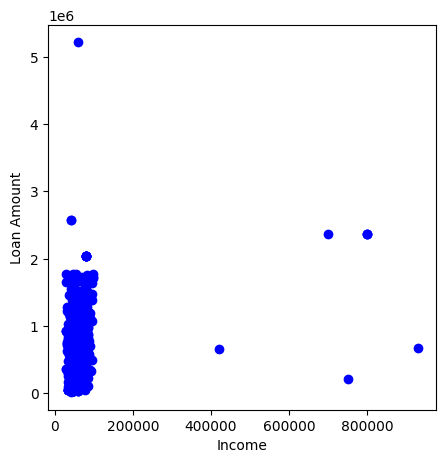

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(customer_profiles[INCOME], customer_profiles[LOAN_AMOUNT], color='blue')
plt.xlabel('Income')
plt.ylabel('Loan Amount')

Text(0, 0.5, 'Use Frequency')

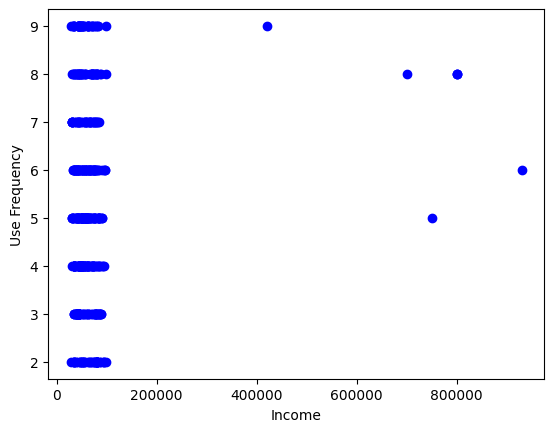

In [7]:
plt.scatter(customer_profiles[INCOME], customer_profiles[USE_FREQ], color='blue')
plt.xlabel(INCOME)
plt.ylabel(USE_FREQ)

Text(0, 0.5, 'Loan Amount')

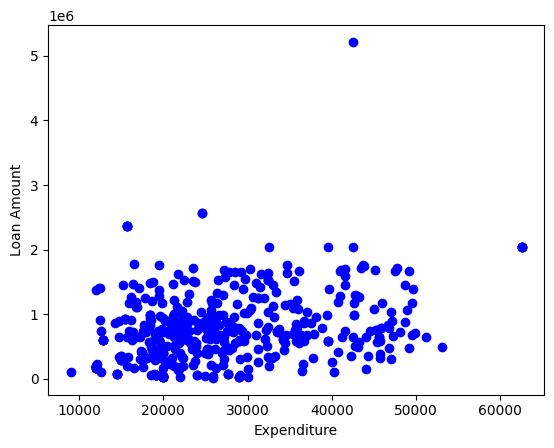

In [8]:
plt.scatter(customer_profiles[EXPENDITURE], customer_profiles[LOAN_AMOUNT], color='blue')
plt.xlabel(EXPENDITURE)
plt.ylabel(LOAN_AMOUNT)

Text(0, 0.5, 'Loan Amount')

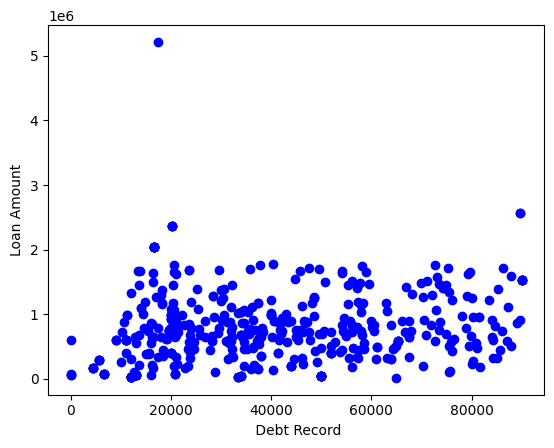

In [9]:
plt.scatter(customer_profiles[DEBT_RECORD], customer_profiles[LOAN_AMOUNT], color='blue')
plt.xlabel(DEBT_RECORD)
plt.ylabel(LOAN_AMOUNT)

Text(0, 0.5, 'Use Frequency')

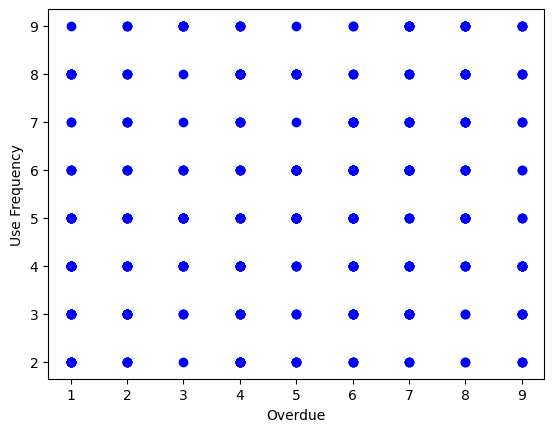

In [10]:
plt.scatter(customer_profiles[OVERDUE], customer_profiles[USE_FREQ], color='blue')
plt.xlabel(OVERDUE)
plt.ylabel(USE_FREQ)

Text(0, 0.5, ' Dishonour of Bill')

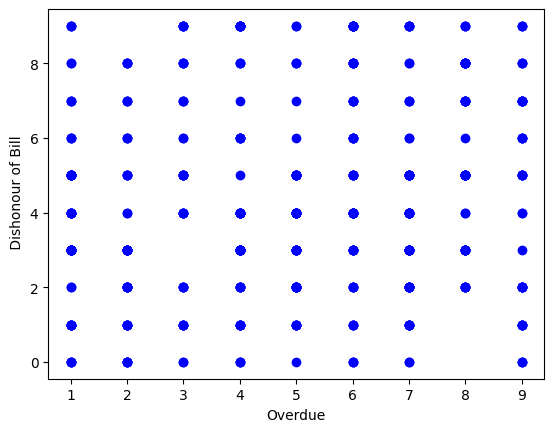

In [11]:
plt.scatter(customer_profiles[OVERDUE], customer_profiles[DISHONORED_BILL], color='blue')
plt.xlabel(OVERDUE)
plt.ylabel(DISHONORED_BILL)

In [12]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(customer_profiles[INCOME], customer_profiles[LOAN_AMOUNT], customer_profiles[EXPENDITURE])
# ax.set_xlabel("Income")
# ax.set_ylabel("Loan Amount")
# ax.set_zlabel("Expenditure")

In [13]:
# customer_profiles[features].hist(figsize=(12, 10),bins=20)
# plt.title('Distribution of Potential Features')

In [14]:
customer_profiles.describe()

,Age,Family Size,Income,Expenditure,Use Frequency,Loan Amount,Overdue,Debt Record,Returned Cheque,Dishonour of Bill
count,449.000000,449.000000,449.000000,449.000000,449.000000,4.490000e+02,449.000000,449.000000,449.000000,449.000000
mean,40.964365,4.518931,68865.351893,27504.463252,5.291759,7.914757e+05,4.928731,40256.525612,4.084633,4.309577
std,10.264083,1.564170,88517.998985,10338.143275,2.083513,5.520810e+05,2.536219,23289.870583,2.834255,2.595484
min,21.000000,2.000000,28366.000000,9000.000000,2.000000,1.535000e+04,1.000000,0.000000,0.000000,0.000000
25%,31.000000,3.000000,45213.000000,19870.000000,4.000000,4.000850e+05,3.000000,20000.000000,2.000000,2.000000
50%,42.000000,4.000000,55999.000000,25605.000000,5.000000,7.229070e+05,5.000000,36394.000000,4.000000,4.000000
75%,50.000000,6.000000,73656.000000,33541.000000,7.000000,1.042737e+06,7.000000,57206.000000,7.000000,6.000000
max,60.000000,7.000000,930000.000000,62541.000000,9.000000,5.214789e+06,9.000000,90000.000000,9.000000,9.000000


In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # VERY IMPORTANT FOR CLUSTERING, ENSURE FAIR DISTANCE COMPUTATIONS

numeric_features = customer_profiles[[INCOME, EXPENDITURE, LOAN_AMOUNT, USE_FREQ, OVERDUE, DEBT_RECORD, DISHONORED_BILL]] 

scaler = StandardScaler()
standard_customer_profiles = scaler.fit_transform(numeric_features) # Scaling numeric features to be clustered

standard_customer_profiles = pd.DataFrame(standard_customer_profiles, columns=numeric_features.columns)

# income -> use freq, loan amount
# expenditure -> loan amount
# loan amount -> debt record
# overdue -> use freq, dishonoured bill

standard_customer_profiles

,Income,Expenditure,Loan Amount,Use Frequency,Overdue,Debt Record,Dishonour of Bill
0,-0.213362,-0.513765,0.378127,0.340305,0.028132,0.113544,1.809164
1,-0.202052,-0.726807,-1.344554,-0.620683,-0.761323,-0.268980,0.266306
2,-0.117795,0.016514,-1.299220,-0.140189,0.422859,-0.833072,-1.276551
3,-0.261236,-1.425196,-0.347212,-1.101177,0.817587,-1.257592,-0.119408
4,-0.286638,-1.501504,-1.072552,-1.101177,-1.156050,0.156529,-0.890837
...,...,...,...,...,...,...,...
444,0.071756,-0.143073,-0.092663,0.820799,0.817587,-0.207941,-0.119408
445,-0.269232,-0.243590,-0.709728,0.340305,0.422859,0.050700,1.809164
446,-0.373531,-0.747240,0.708668,0.340305,0.422859,-0.125453,-0.505123
447,-0.372400,-0.625225,-0.835748,0.340305,1.212314,0.252042,1.423449


## Clustering
* Utilize clustering to group customers into unique groups based on similar characteristics and behavior.
* https://www.youtube.com/watch?v=iNlZ3IU5Ffw : Used this video for help

(array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
         115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
         225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
         335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
         445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
         555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
         665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
         775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
         885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
         995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
        1105, 1115, 1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205,
        1215, 1225, 1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315,
        1325, 1335, 1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425,
        1435, 1445, 1455, 1465, 1475, 

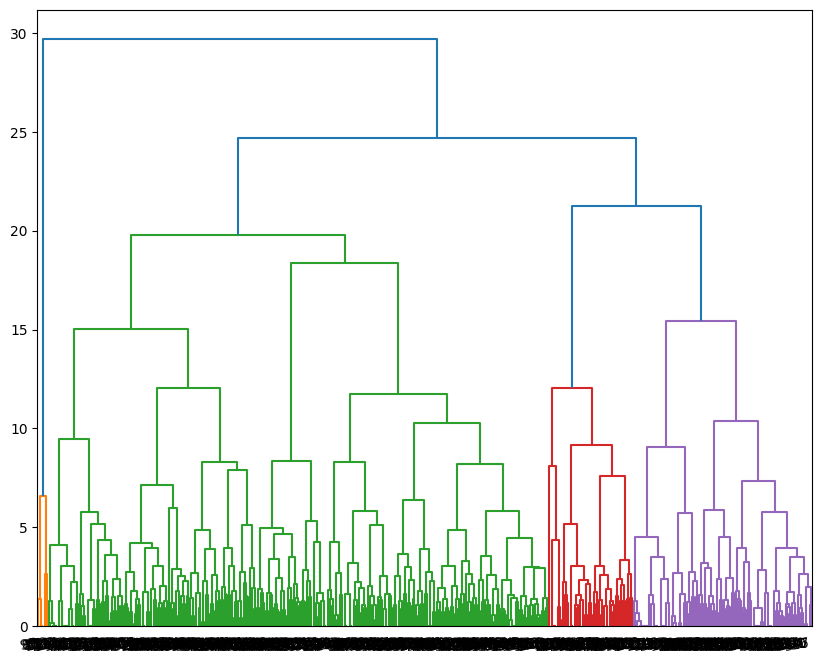

In [26]:
# Perform hierarchical clustering
linkage_matrix = linkage(standard_customer_profiles, method='ward')  # 'ward' linkage is commonly used, but you can choose other methods
fig = plt.figure(figsize=(10, 8))
# Plot the dendrogram
dn = dendrogram(linkage_matrix)

plt.xticks(rotation=10, ha='right', fontsize='10')


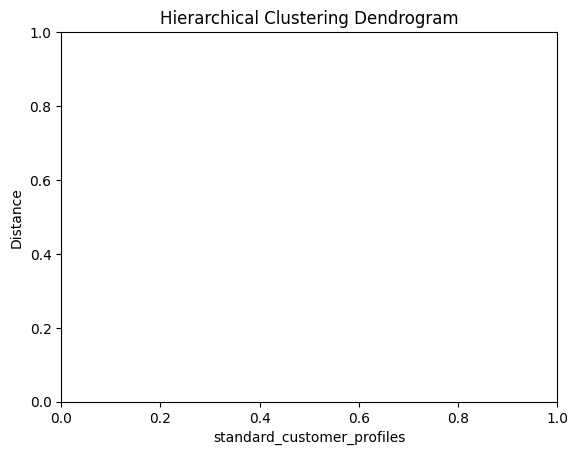

In [17]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('standard_customer_profiles')
plt.ylabel('Distance')
plt.show()

In [18]:
# Specify the number of clusters
num_clusters = 4
# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(standard_customer_profiles)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Access information about cluster 12 (hypothetical, assuming there are at least 10 clusters)
cluster_info = (slice(None, None, None), 9)
result = kmeans.cluster_centers_[cluster_info]

result

# ALIYAAAAAA
# This part errors due to index issues, maybe we can just use mine?

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


IndexError: index 9 is out of bounds for axis 1 with size 7

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

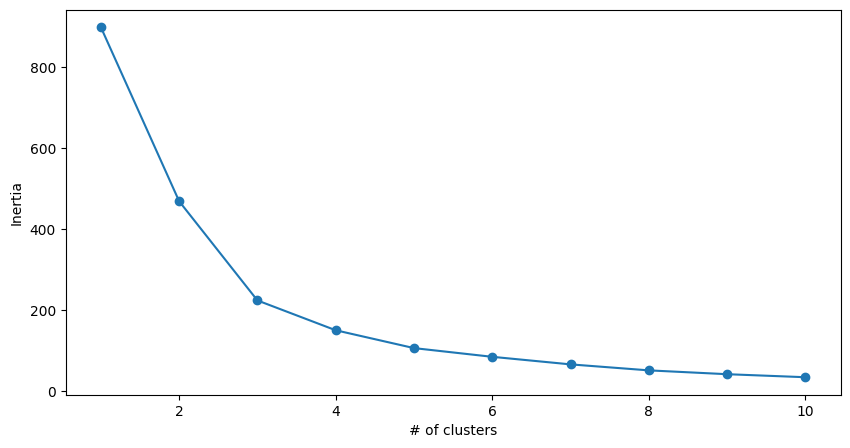

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

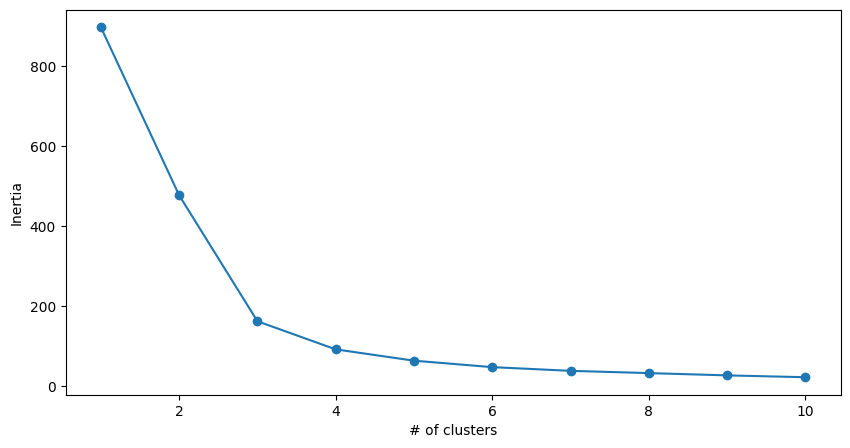

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

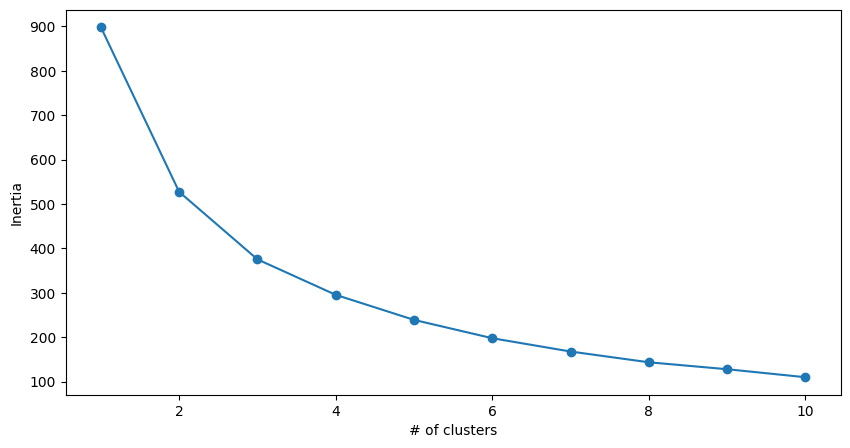

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

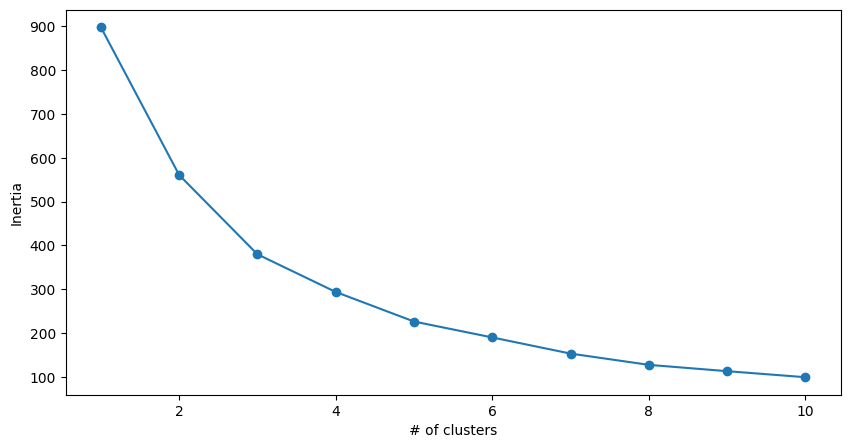

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

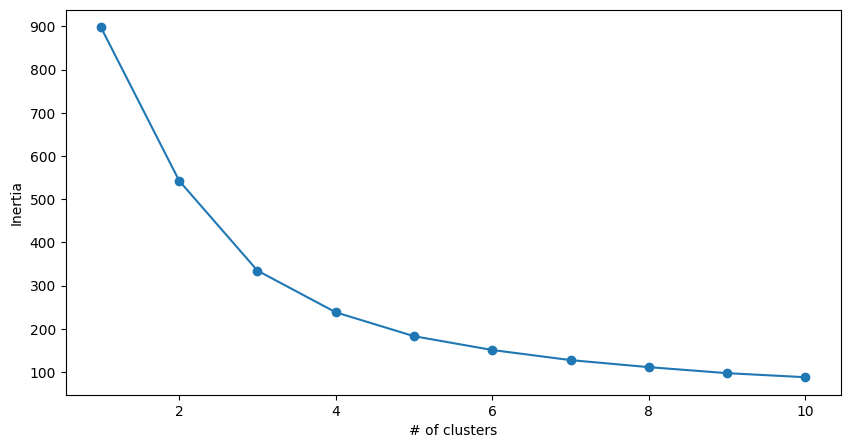

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

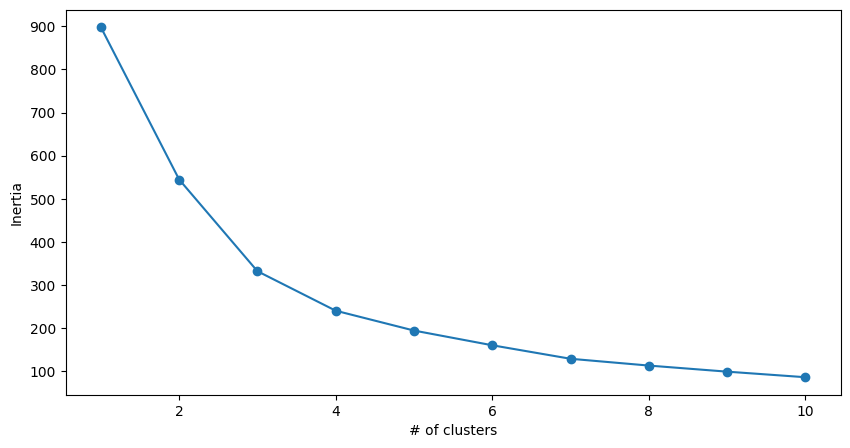

In [ ]:
# Optimize number of clusters using Elbow Method, refer to video linked above for more help
def optimize_k_means(data: pd.DataFrame, max_k: int):
    mean, ineritia = [], []
    
    for k in range(1, max_k):
        kmean = KMeans(n_clusters=k)
        kmean.fit(data)
        
        mean.append(k)
        ineritia.append(kmean.inertia_)
        
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(mean, ineritia, 'o-')
    plt.xlabel('# of clusters')
    plt.ylabel('Inertia')
    plt.show()
    
# optimize_k_means(standard_customer_profiles[[INCOME, LOAN_AMOUNT]], 11)
# optimize_k_means(standard_customer_profiles[[INCOME, USE_FREQ]], 11)
# optimize_k_means(standard_customer_profiles[[EXPENDITURE, LOAN_AMOUNT]], 11)
# optimize_k_means(standard_customer_profiles[[DEBT_RECORD, LOAN_AMOUNT]], 11)
# optimize_k_means(standard_customer_profiles[[OVERDUE, USE_FREQ]], 11)
# optimize_k_means(standard_customer_profiles[[OVERDUE, DISHONORED_BILL]], 11)


In [ ]:
kmeans = KMeans(n_clusters=4)

kmeans.fit(standard_customer_profiles[[INCOME, LOAN_AMOUNT]])


# kmeans.fit(standard_customer_profiles[[INCOME, USE_FREQ]])


# kmeans.fit(standard_customer_profiles[[EXPENDITURE, LOAN_AMOUNT]])


# kmeans.fit(standard_customer_profiles[[DEBT_RECORD, LOAN_AMOUNT]])


# ---- the ones below kinda sucked

# kmeans.fit(standard_customer_profiles[[OVERDUE, USE_FREQ]]) 


# kmeans.fit(standard_customer_profiles[[OVERDUE, DISHONORED_BILL]])



customer_profiles['kmeans'] = kmeans.labels_
centroids = kmeans.cluster_centers_

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/var/folders/nf/xhd092257nx_p1cp4wt9pghr0000gn/T/ipykernel_57200/2106567690.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profiles['kmeans'] = kmeans.labels_


Text(0, 0.5, ' Dishonour of Bill')

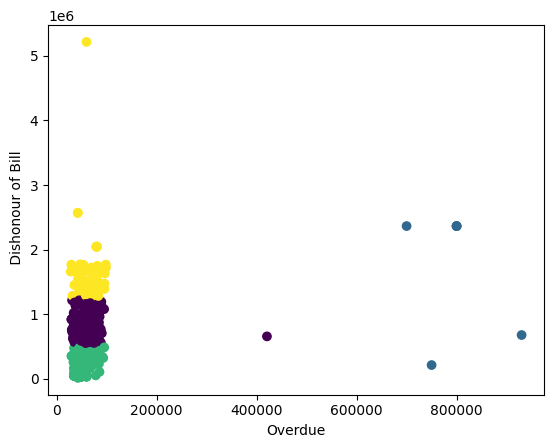

In [ ]:
plt.scatter(x=customer_profiles[INCOME], y=customer_profiles[LOAN_AMOUNT], c=customer_profiles['kmeans'])
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='black', s=169, linewidths=2, zorder=10)
plt.xlabel(OVERDUE)
plt.ylabel(DISHONORED_BILL)
